In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix, plot_roc_curve, auc
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from numpy.random import randn

import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn

In [2]:
path = Path(os.getcwd()).parents[0]

extpath = os.path.join(path, 'data/external_data')

In [3]:
figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

fig2path = os.path.join(figpath, 'FigS2')
hfn.dir_check(fig2path)

fig2panelpaths = os.path.join(fig2path, 'panels')
hfn.dir_check(fig2panelpaths)

In [4]:
data = pd.read_hdf(os.path.join(extpath, 'data_log_all.h5'))

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
data[['starter', 'input']] = scaler.fit_transform( data[['starter', 'input']])

In [7]:
# shuffle data
data = data.sample(frac=1, random_state=0).reset_index(drop=True)

In [8]:
# data_filt = data[data.cell_type.isin(['Pyr','interneuron'])]
data_filt = data.copy()
data_filt = data_filt.reset_index(drop=True).dropna()

In [9]:
data_filt.rabies = pd.Categorical(data_filt.rabies)
data_filt.target = data_filt.rabies.cat.codes

In [10]:
# set targets, features
target = data_filt.target
features = pd.get_dummies(pd.DataFrame(data_filt[['cell_type', 'starter','input']]))
features_names = ['cell_type','starter','input']

In [11]:
data_filt

,ID,starter,input,condition,dataset,rabies,G,cell_type,area
0,8,0.523503,0.584816,PV_V1_P30,Pouchelon,N2C,G-N2C,interneuron,Ctx
1,#04 ILA,0.583399,0.551753,ILA VIP,Sun,SAD,G,interneuron,Ctx-PFC
2,2,0.540617,0.780014,PV_M2_P30,Pouchelon,N2C,G-N2C,interneuron,Ctx
3,16,0.813716,0.857462,Camk2a - mIC,Gehrlach,SAD,G,Pyr,IC
4,64_NAcMed 4,0.355991,0.356695,vGluT2-Cre cTRIO,Beier,SAD,G,unknown,VTA
...,...,...,...,...,...,...,...,...,...
297,419719,0.365567,0.899508,PV-Cre,Graham,N2C,G-N2C,interneuron,Ctx-IL
298,1164,0.734140,0.683986,Gad2 - mIC,Gehrlach,SAD,G,Pyr,IC
299,BX_Scnn1a-18_1,0.422706,0.746049,Scnn1a,Brown,SAD,G,Pyr,Ctx-Vis
300,38_mPFC 2,0.325047,0.441718,DAT-Cre cTRIO,Beier,SAD,G,unknown,VTA


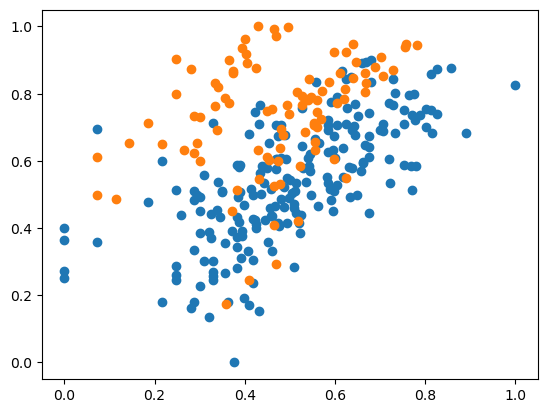

In [12]:
plt.scatter(data_filt[data_filt.rabies == 'SAD'].starter, data_filt[data_filt.rabies == 'SAD'].input)
plt.scatter(data_filt[data_filt.rabies == 'N2C'].starter, data_filt[data_filt.rabies == 'N2C'].input)

# classification on full dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target,
                                                    test_size = 0.2, 
                                                    random_state = 42)

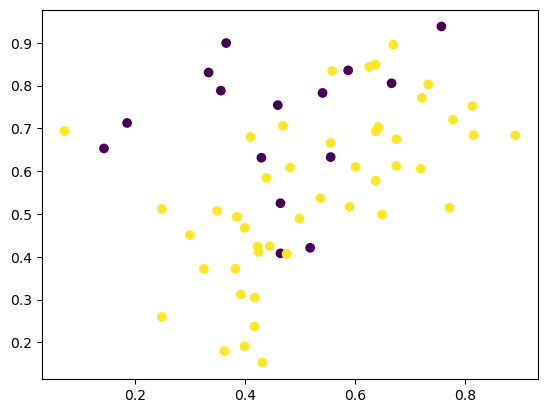

In [14]:
svc = LinearSVC(random_state=42)
model = svc.fit(X_train, y_train)
preds = model.predict(X_test)
plt.scatter(X_test.starter, X_test.input, c = y_test)
g=plt.scatter(X_test.starter, X_test.input, c = preds, s=110, linewidths=2)
g.set_facecolor('none')

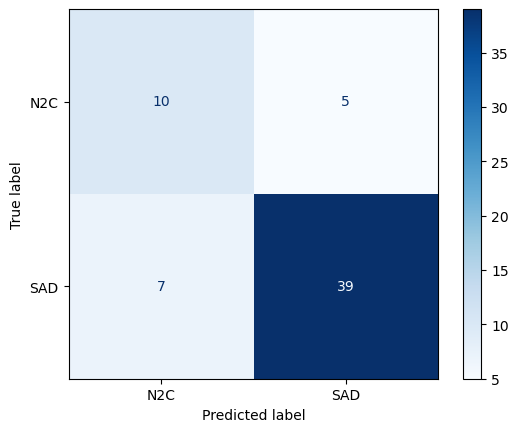

In [15]:
plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Blues, display_labels=data_filt.rabies.unique())  

In [16]:
print(accuracy_score(y_test, preds))

0.8032786885245902


# with cross-validation

In [17]:
scores = []
preds = []
clf = LinearSVC()#OneVsRestClassifier(LinearSVC()) #OneVsRestClassifier(SVC(kernel = 'rbf', gamma = 2))# OneVsRestClassifier(LinearSVC()) # 
cv = StratifiedKFold(n_splits=4, random_state = 42, shuffle = True) #random_state = 42
cvscores = []
Xtrain = []
Xtest = []
ytrain = []
ytest = []

for train_index, test_index in cv.split(features, target):
#     print("Train Index: ", train_index, "\n")
#     print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = features.iloc[train_index, :], features.iloc[test_index,:], target.iloc[train_index], target.iloc[test_index]
    Xtrain.append(X_train)
    ytrain.append(y_train)
    Xtest.append(X_test)
    ytest.append(y_test)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    cvscores.append(cross_val_score(clf, X_test, y_test, scoring = 'accuracy', cv = cv))
    preds.append(clf.predict(X_test))

In [18]:
np.mean(scores)

0.8405701754385966

In [19]:
cross_val_score(clf, features, target, cv=cv)

array([0.82894737, 0.85333333, 0.81333333, 0.86666667])

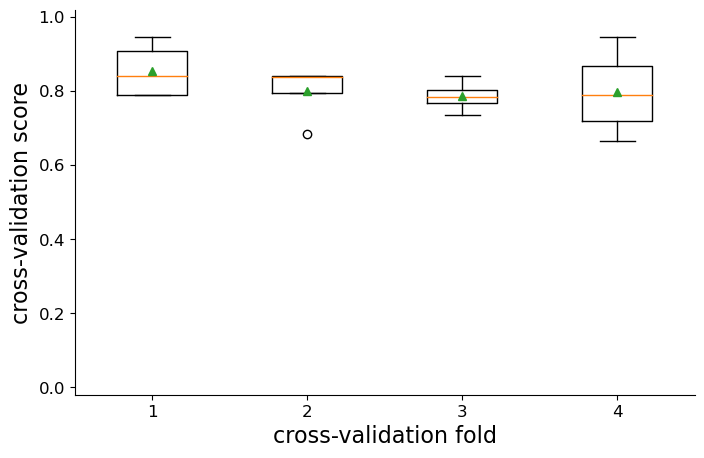

In [20]:
sc = plt.boxplot(cvscores, showmeans = True)
plt.ylim(-0.02,1.02)
plt.xlabel('cross-validation fold', fontsize = 16)
plt.ylabel('cross-validation score', fontsize = 16)
ax = plt.gca()
ax.tick_params(labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.gcf().set_size_inches(8,5)
plt.savefig(os.path.join(fig2panelpaths, 'fig_S2B.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(fig2panelpaths, 'fig_S2B.eps'), bbox_inches = 'tight', format = 'eps', dpi = 200)

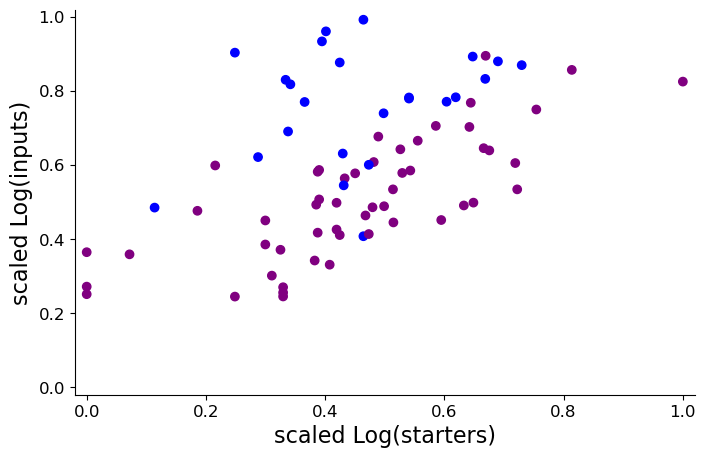

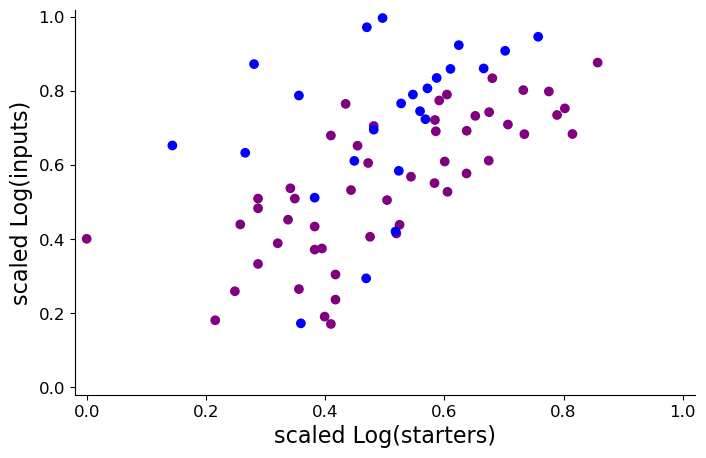

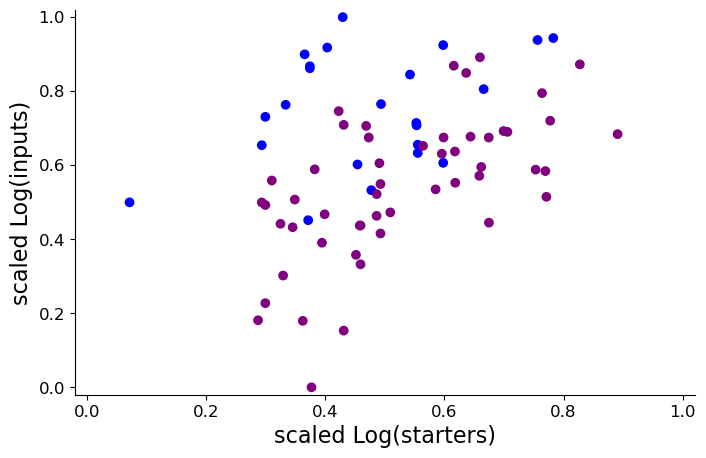

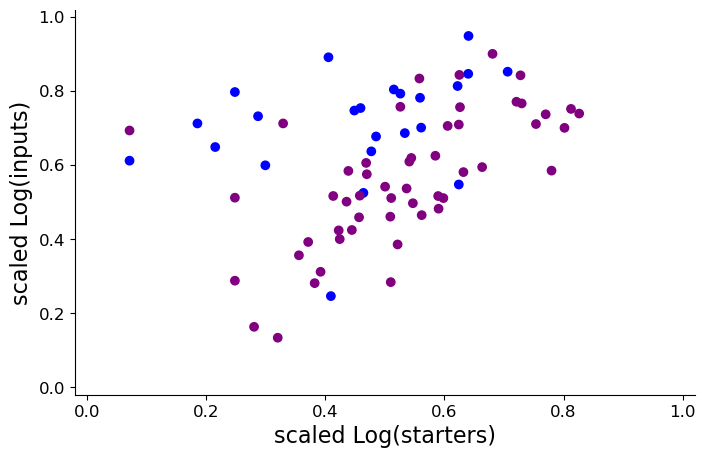

In [21]:
colors = ['blue','purple']

for i in range (4):
    plt.figure()

    f = plt.scatter(Xtest[i].starter, Xtest[i].input, c = ytest[i], cmap=matplotlib.colors.ListedColormap(colors))
    g = plt.scatter(Xtest[i].starter, Xtest[i].input, c = preds[i], s=110, linewidths=2, cmap=matplotlib.colors.ListedColormap(colors))
    g.set_facecolor('none')
    plt.xlabel('scaled Log(starters)', fontsize = 16)
    plt.ylabel('scaled Log(inputs)', fontsize = 16)
    plt.ylim(-0.02,1.02)
    plt.xlim(-0.02,1.02)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize=12)
    plt.gcf().set_size_inches(8,5)
    plt.savefig(os.path.join(fig2panelpaths, 'fig_S2A_'+str(i)+'.png'), bbox_inches = 'tight')
    plt.savefig(os.path.join(fig2panelpaths, 'fig_S2A_'+str(i)+'.eps'), bbox_inches = 'tight', format = 'eps', dpi = 200)